## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand

from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE
from scipy.spatial import distance

## Load Data

In [2]:
# loading entire high-dimensional trajectory
x = loadmat('trajectory_normalized.mat')
trajectory = x['multi_D_traj_norm']
trajectory.shape

(540000, 60)

## Data Cleansing and Exploration

Text(0, 0.5, 'Occurences')

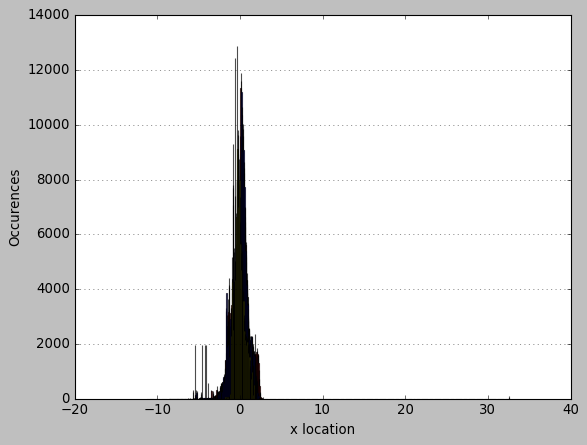

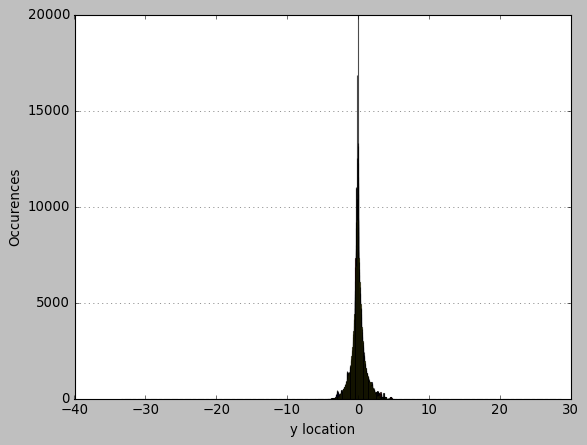

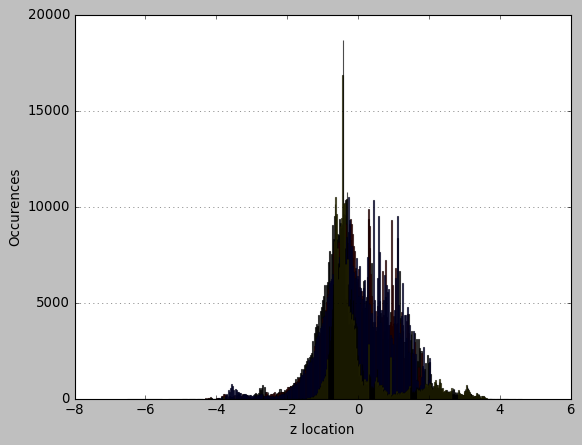

In [3]:
# removing invalid values (e.g. NaN)
# input data is already normalized (z-score) but needs to get rid of non-valued datapoints
nan_cols = []
for i in range(trajectory.shape[1]):
    if np.isnan(trajectory[:, i]).all():
        nan_cols.append(i)

trajectory = np.delete(trajectory, nan_cols, 1)
trajectory.shape

# plotting histogram of the x,y and z location of the first dimension of high-d trajectory
# x-location
fig = plt.figure(1)
n, bins, patches = plt.hist(x=trajectory[:, 0], bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 3], bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 6], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 9], bins='auto', color='yellow',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('x location')
plt.ylabel('Occurences')


# y-location
fig = plt.figure(2)
n, bins, patches = plt.hist(x=trajectory[:, 1], bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 4], bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 7], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 10], bins='auto', color='yellow',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('y location')
plt.ylabel('Occurences')

# z-location
fig = plt.figure(3)
n, bins, patches = plt.hist(x=trajectory[:, 2], bins='auto', color='black',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 5], bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 8], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=trajectory[:, 11], bins='auto', color='yellow',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('z location')
plt.ylabel('Occurences')

## Dimensionality Reduction: PCA

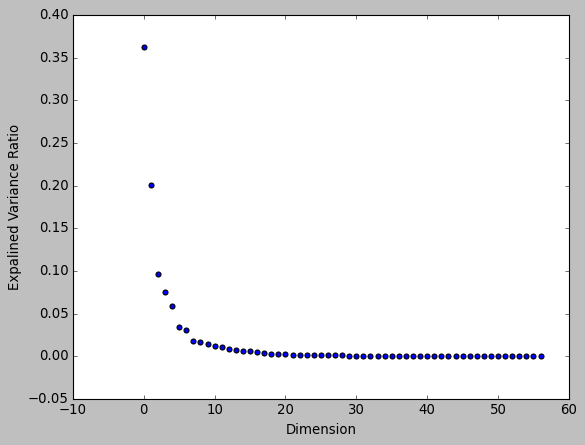

(540000, 3)

In [4]:
# inspecting inter-dimensional variance with PCA
pca = PCA()
pca.fit(trajectory)

plt.scatter(np.arange(trajectory.shape[1]), pca.explained_variance_ratio_)
plt.ylabel('Expalined Variance Ratio')
plt.xlabel('Dimension')
plt.show()

# reduce data according to explained variance values using linear PCA
pca = PCA(n_components=3)
reduced_traj = pca.fit_transform(trajectory)
reduced_traj.shape

## Data Exploration

Text(0, 0.5, 'Frequency')

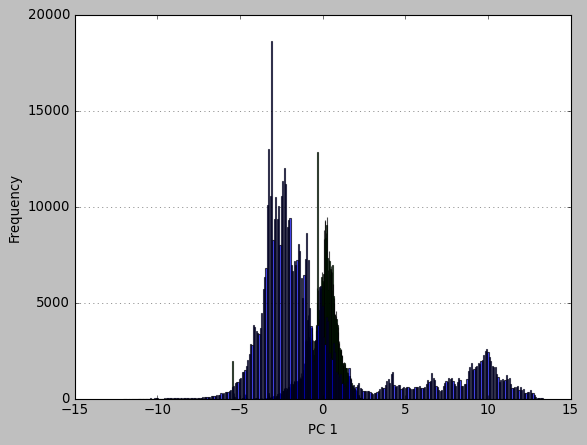

In [5]:
# plotting histogram of the x-location of the first dimension of non-reduced trajectory
n, bins, patches = plt.hist(x=trajectory[:, 0], bins='auto', color='green',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('x location')
plt.ylabel('Frequency')

# plotting histogram of the x-location of the first dimension for reduced trajectory (PCA)
n, bins, patches = plt.hist(x=reduced_traj[:, 0], bins='auto', 
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('PC 1')
plt.ylabel('Frequency')

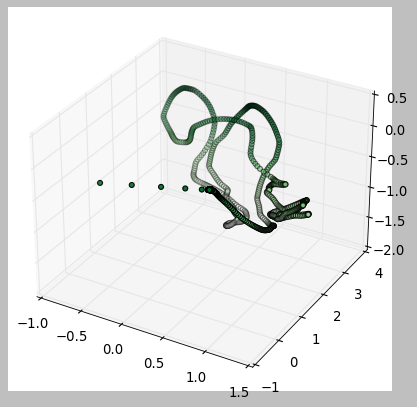

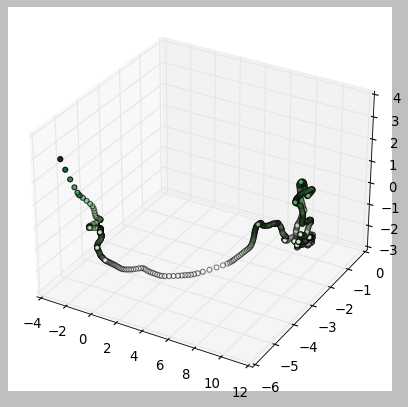

In [6]:
traj_length = 900

fig = plt.figure(1)
# plotting 3D trajectory taking first 3 dimensions of the high-d trajectory
ax = plt.axes(projection='3d')
zdata = trajectory[0:traj_length, 2]
xdata = trajectory[0:traj_length, 0]
ydata = trajectory[0:traj_length, 1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

fig = plt.figure(2)
# plotting 3D reduced trajectory (PCA)
ax = plt.axes(projection='3d')
zdata = reduced_traj[0:traj_length, 2]
xdata = reduced_traj[0:traj_length, 0]
ydata = reduced_traj[0:traj_length, 1]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

## Entropy Analysis

### Helper functions

In [50]:
def prob_vector(raw_data, max_size, min_, decimals=1):
    rounded_data = [(round(x * 10**(decimals)))/(10**decimals) for x in raw_data]
    sorted_data = np.sort(rounded_data)
    sorted_data = np.array(sorted_data, dtype=np.float64)

    already_seen = []
    prob_vector = np.zeros((max_size+1))
    occurrences = 0
    idx = 0
    for datapoint in sorted_data:
        if datapoint not in already_seen:
            occurrences = np.count_nonzero(sorted_data == datapoint)
            already_seen.append(datapoint)
            idx = int((datapoint - min_)/(1/10**decimals))
            prob_vector[idx] = (occurrences/len(sorted_data))
    
    return prob_vector

In [16]:
def get_mPE_matrix(reduced_traj, bins_number, traj_number, orders):
    mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
    traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
    for a, order in enumerate(orders):
        for i in range(bins_number):
            idx = 0
            idx_1 = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = i*bins_number*traj_length 
                traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                [HH,hh_norm]=mPE(traj,order)
                mPE_vector[i, idx , a] = HH
                idx += 1
                
    return mPE_vector


In [ ]:
# Entropy Calculation:
# - Divide entire trajetcory in 'bins_number' bins
# - Divide each bin for 'traj_number' trajectories
# - Calculate mPE for each of these trajectories 

bins_number = 30
traj_number = 30
orders = [3]

mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders)

Text(0, 0.5, 'Occurences')

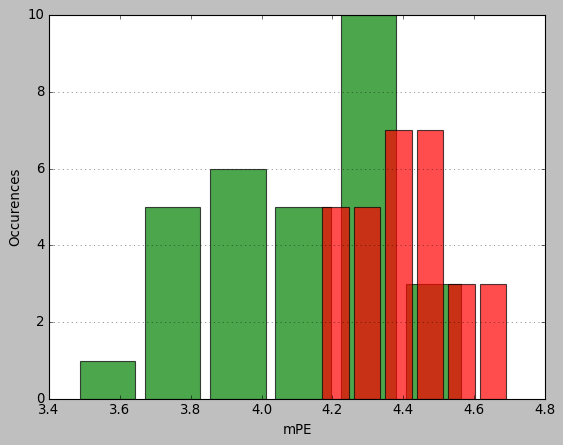

In [22]:
# entropy distribution visualization
# plotting mpE of the first bin 
bin_n = 1
order_n = 0
fig = plt.figure(1)
n, bins, patches = plt.hist(x= mPE_vector[bin_n, :, order_n] , bins='auto', color='green',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x= mPE_vector[mPE_vector.shape[0]-3, :, order_n] , bins='auto', color='red',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mPE')
plt.ylabel('Occurences')

Text(0, 0.5, 'J-S Divergence')

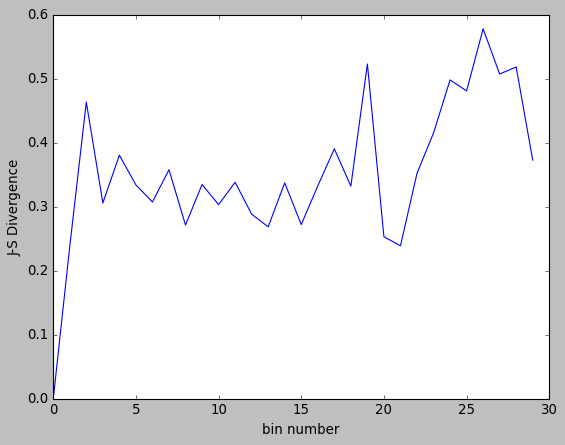

In [51]:
min_ = float('inf')
max_ = float('-inf')
for order in range(mPE_vector.shape[2]):
    for bin_ in range(mPE_vector.shape[0]):
        for traj in range(mPE_vector.shape[1]):
            if mPE_vector[traj, bin_, order] > max_:
                max_ = mPE_vector[traj, bin_, order]
            elif mPE_vector[traj, bin_, order] < min_:
                min_ = mPE_vector[traj, bin_, order]

truncation_decimal = 1
min_ = (round(min_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_ = (round(max_ * 10**(truncation_decimal)))/(10**truncation_decimal)
max_size = int((max_ - min_)/(1/(10**truncation_decimal)))

# plotting J-S divergence as a function of bin number
compare_to = prob_vector(mPE_vector[0, :, 0], max_size, min_)
js_vector = np.zeros((mPE_vector.shape[0]))
for i in range(mPE_vector.shape[0]):
    js_vector[i] = distance.jensenshannon(prob_vector(mPE_vector[i, :, 0], max_size, min_), compare_to)

fig = plt.figure(2)
# plotting velocity profile of mouse (point-wise)
plt.plot(np.arange(mPE_vector.shape[0]), js_vector)
plt.xlabel('bin number')
plt.ylabel('J-S Divergence')


In [ ]:
# Calculate instantaneous velocity of each datapoint (maybe only consider x-y dims)
lest_varaince_dim = 8*3
vel_vector = np.zeros((reduced_traj.shape[0], 1))
last_point = trajectory[1, lest_varaince_dim:lest_varaince_dim+3]
for idx, point in enumerate(trajectory[:, lest_varaince_dim:lest_varaince_dim+3]):
    vel = np.linalg.norm((abs(point) - abs(last_point)))
    vel_vector[idx] = vel
    last_point = point

fig = plt.figure(3)
# plotting velocity profile of mouse (point-wise)
plt.plot(np.arange(len(vel_vector)), vel_vector)
plt.xlabel('time(s)')
plt.ylabel('relative velocity')